In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Мне очень понравился состав проекта, который был во втором вебинаре, буду его придерживаться.

# 1. Поставнока задачи

Ваша задача этом соревновании - предсказать средний балл на экзамене по математике, который получают ученики репетиторов из датасета test.csv. Вам будут даны два датасета: train.csv (содержит признаки и целевую переменную) и test.csv (только признаки).

# 2. Получение данных

Данные уже получены и выгружены в файлы.

#### Подключение нужных библиотек и данных

In [2]:
import numpy as np
import pandas as pd
import random
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

#### Читаем и смотрим на данные

In [3]:
TRAIN_DATASET_PATH = 'kaggle/input/tutors-expected-math-exam-results/train.csv'
TEST_DATASET_PATH = 'kaggle/input/tutors-expected-math-exam-results/test.csv'
SUBMIT_DATASET_PATH = 'kaggle/input/tutors-expected-math-exam-results/submission_example.csv'

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [5]:
train_df.tail()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
9995,9995,44.0,0.0,1700.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,78.0
9996,9996,51.0,0.0,1700.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0
9997,9997,34.0,1.0,1250.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0
9998,9998,33.0,3.0,1100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0
9999,9999,35.0,0.0,1450.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [6]:
test_df.tail()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
9995,19995,42.0,0.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,19996,51.0,2.0,2200.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0
9997,19997,33.0,5.0,1100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,19998,48.0,0.0,1750.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
9999,19999,49.0,5.0,2000.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_df.dtypes

Id                       int64
age                    float64
years_of_experience    float64
lesson_price           float64
qualification          float64
physics                float64
chemistry              float64
biology                float64
english                float64
geography              float64
history                float64
mean_exam_points       float64
dtype: object

In [8]:
train_df['Id'] = train_df['Id'].astype(str)

In [9]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 10000


Описание датасета

* Id - идентификационный репетитора
* age - возраст репетитора
* years_of_experience - количество лет опыта
* lesson_price - стоимость занятия
* qualification - квалификация
* physics - преподавание по физике
* chemistry - преподавание по химии
* biology - преподавание по биологии
* english - преподавание по английскому
* geography - преподавание по географии
* history - преподавание по химии
* mean_exam_points - средний балл ученика по математике

# 3. Анализ данных

In [10]:
train_df.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [11]:
train_df.isna().sum()

Id                     0
age                    0
years_of_experience    0
lesson_price           0
qualification          0
physics                0
chemistry              0
biology                0
english                0
geography              0
history                0
mean_exam_points       0
dtype: int64

По первому взгяду на данные, мы видим что:

Все данные хорошие, пропусков в данных не наблюдается, аномалий нигде нет (возраст, опыт, цена, средний балл находятся в реальных границах).

*qualification* - является фактически категорийным полем, мы точно не знаем как заполнено это поле, но можем предположить, что "Чем выше значение qualification тем выше квалификация преподавателя".

*physics, chemistry, biology, english, geography, history* - бинарные поля.

# 4. Визуализация данных

Я, конечно, все посмотрел, но интерес представляют следующие:

In [12]:
# вывод распредления
def distributionPlot(df, param, bins=100):
    plt.figure(figsize = (16, 8))

    df[param].hist(bins=bins)
    plt.ylabel('Count')
    plt.xlabel(param)

    plt.title(param + ' distribution')
    plt.show()
    
# Вывод зависимости таргета
def correlationPlot(df, param, target="mean_exam_points"):
    plt.figure(figsize = (16, 8))
    
    sns.scatterplot(x=df[param], y=df[target])
    plt.ylabel(target)
    plt.xlabel(param)

    plt.title(target + ' = F(' + param + ')')
    plt.show()

### mean_exam_points

Посмотрим на распредлеение целевой переменной.

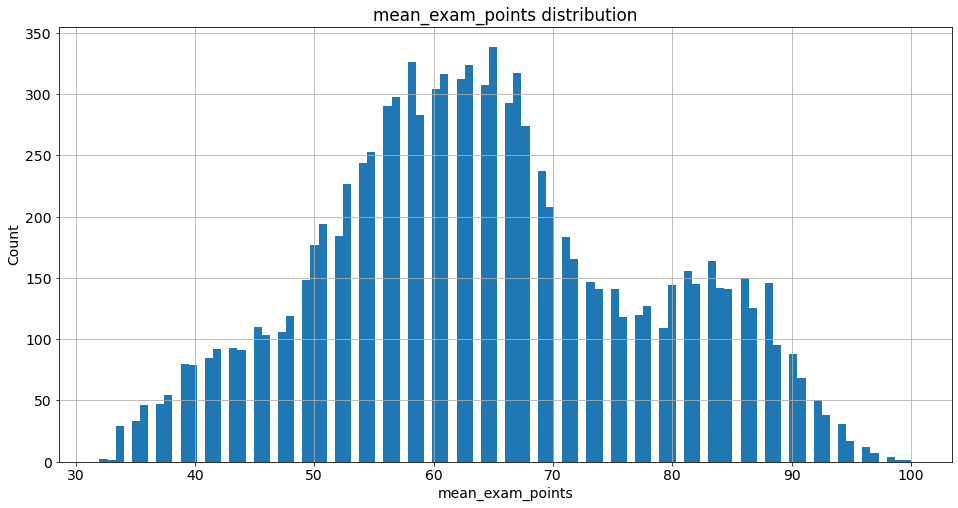

In [13]:
distributionPlot(train_df, 'mean_exam_points')

Судя по этому графику есть некоторое наложение двух нормальных распределений. Возможно удастся вычленить их по каким-то параметрам.

Попробуем построить такие же распределения в зависимости от квалификации преподавателей

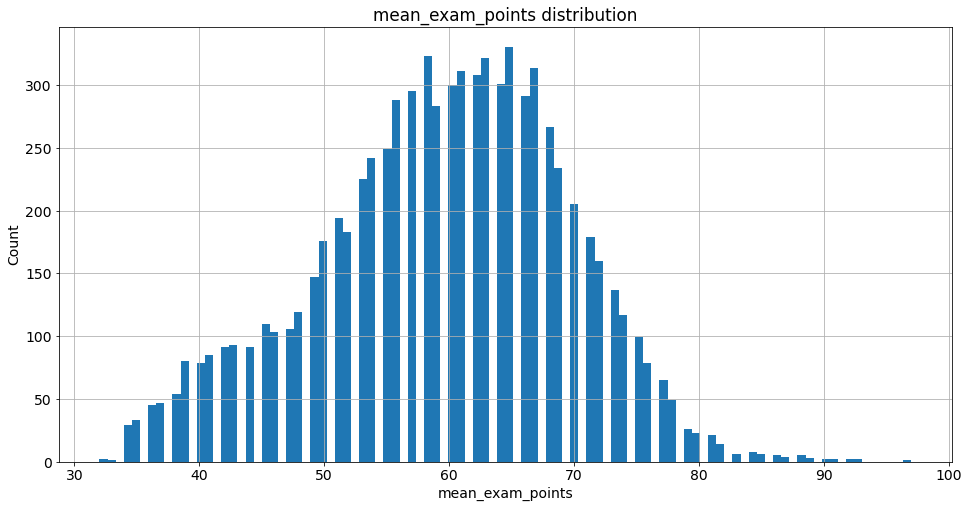

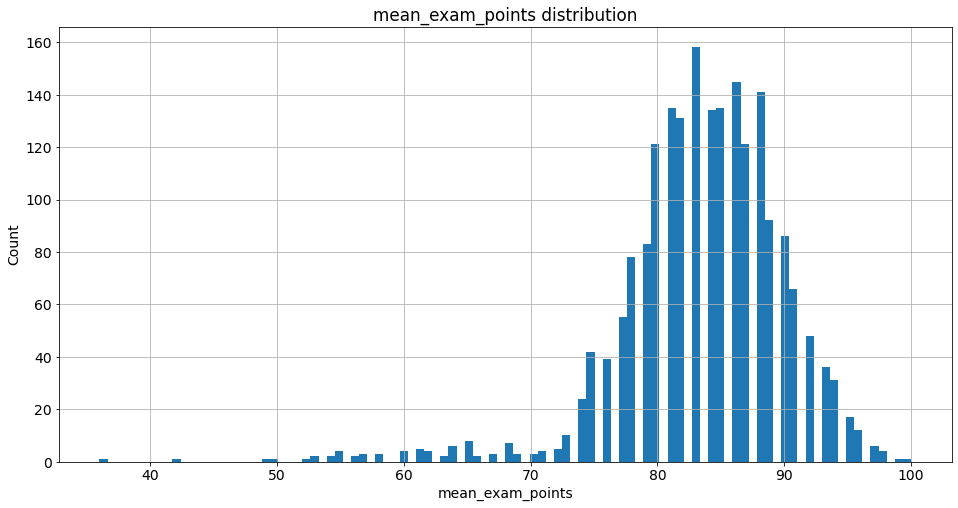

In [14]:
distributionPlot(train_df.loc[train_df['qualification']<=2], 'mean_exam_points')
distributionPlot(train_df.loc[train_df['qualification']>=3], 'mean_exam_points')

Здесь прекрасно видны эти 2 пика.

Нам важно разделить 2 этих группы, для этого создадим 2 новых бинарных признака, чтобы при построении дерева или регрессии использовать их.

### age	

Посмотрим на распредлеение возраста.

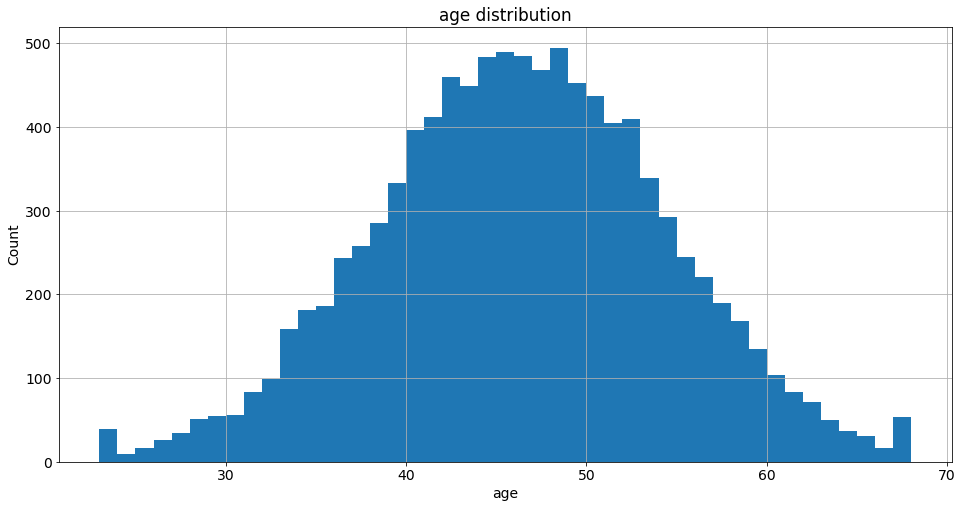

In [15]:
distributionPlot(train_df, 'age', bins=45)

Практически идеальное нормальное распределение.

Изучим зависимость таргета от этой переменной.

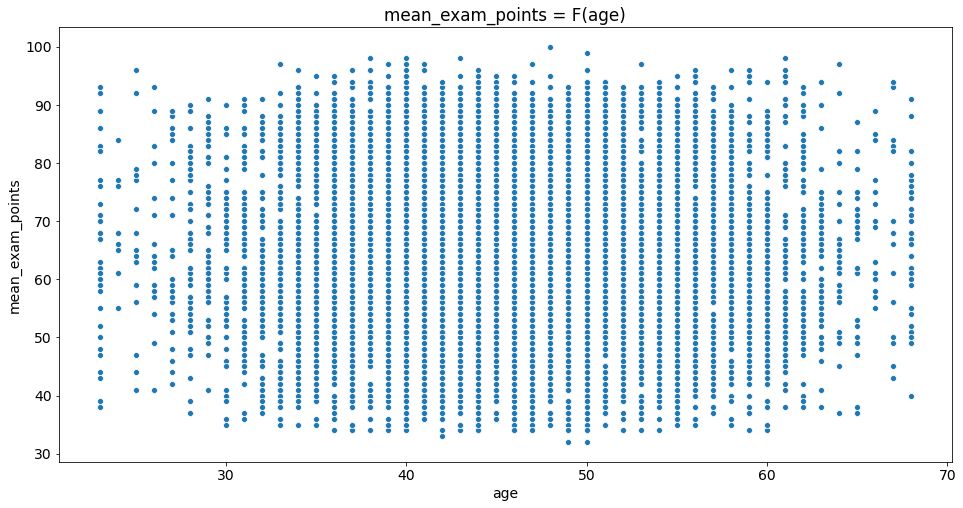

In [16]:
correlationPlot(train_df, 'age')

Как и предполагалось, никакой линейной зависимостью и не пахнет.

### years_of_experience	

Посмотрим на распредлеение и связь с таргетом.

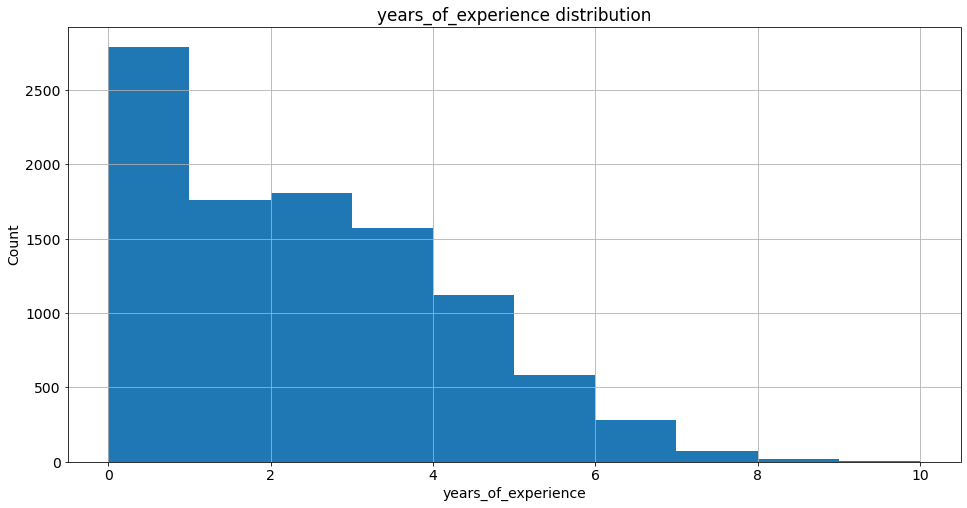

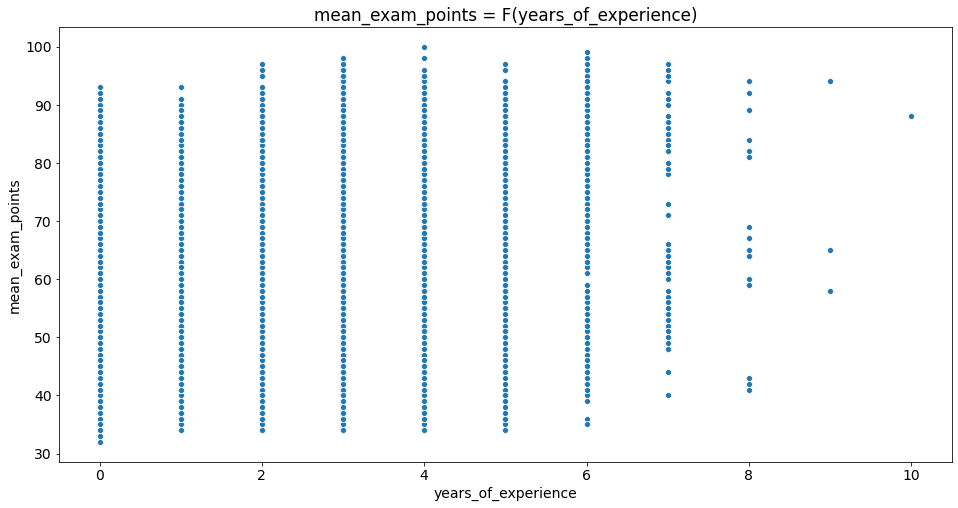

In [17]:
distributionPlot(train_df, 'years_of_experience', bins=10)
correlationPlot(train_df, 'years_of_experience')

### lesson_price

Посмотрим на распредлеение стоимости часа.

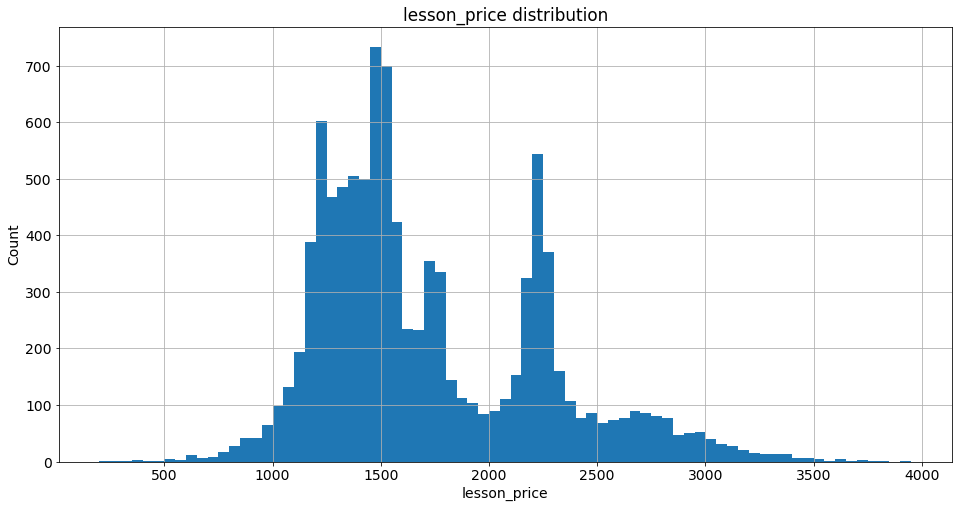

In [18]:
distributionPlot(train_df, 'lesson_price', bins=75)

Это распределение, в какой-то степени, по форме повторяет распределение баллов.
Возможно именно этот параметр хорошо коррелирован с баллом и имеет относительно линейнуюю зависимость.

Построим зависимость от таргета.

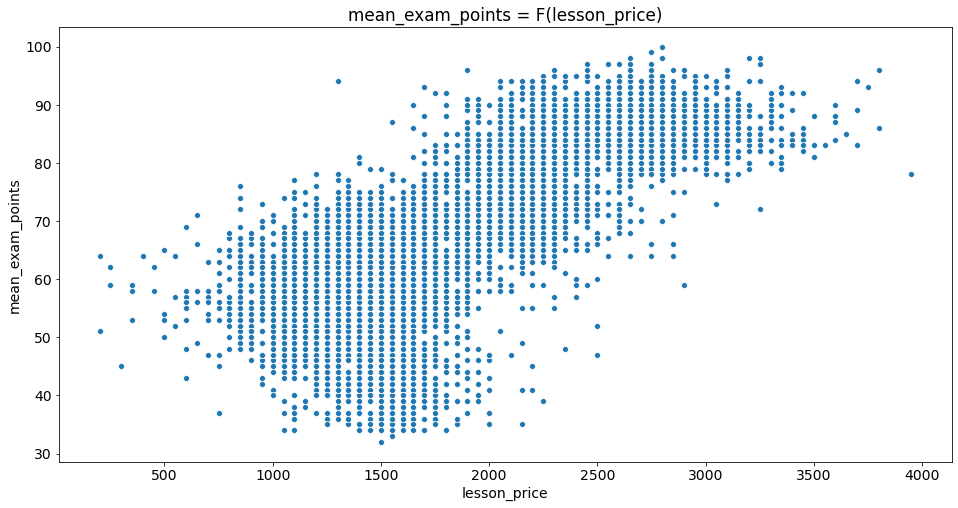

In [19]:
correlationPlot(train_df, 'lesson_price')

Относительно хорошая линейная зависимость. Но есть группа "переоцененных" преподавателей в бюджетном ценовом сегменте (от 1000 до 2000 р.)

### qualification

In [20]:
train_df['qualification'].value_counts()

1.0    4884
2.0    3087
3.0    1979
4.0      50
Name: qualification, dtype: int64

Видно, что число преподавателей убывает по мере роста квалификации, это согласуется с предположением: "Чем выше значение qualification тем выше квалификация преподавателя".

Проверим средний балл и цену для каждой из квалификаций.

In [21]:
for x in [1,2,3,4]:
    print(str(x)+":"+str(train_df.loc[train_df['qualification']==x]['mean_exam_points'].mean())+'/'+str(train_df.loc[train_df['qualification']==x]['lesson_price'].mean()))

1:55.91932841932842/1341.4414414414414
2:65.05668934240363/1778.2150955620343
3:83.49418898433552/2440.298130368873
4:84.66/2415.0


Видно, что характер данных не противоречит нашей гипотезе, посмотрим на таргет.

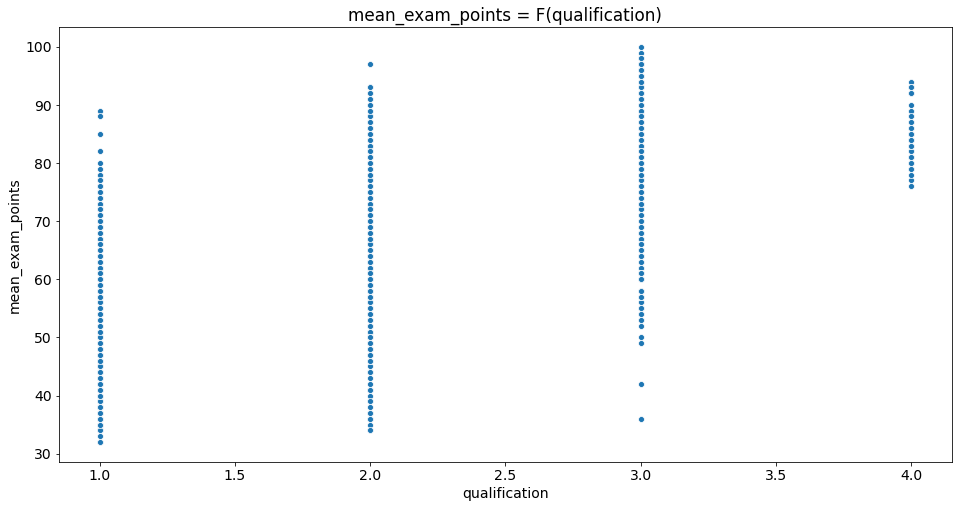

In [22]:
correlationPlot(train_df, 'qualification')

Вроде бы зависимость есть, но в 4 уровне она нарушает линейность. Возможно имеет смысл объединить 3 и 4 уровни.

#### physics, chemistry, biology, english, geography, history

Ничего примечательного обычные бинарные признаки

In [23]:
for x in ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']:
    print(x+":")
    print(train_df[x].value_counts())

physics:
0.0    6250
1.0    3750
Name: physics, dtype: int64
chemistry:
0.0    8671
1.0    1329
Name: chemistry, dtype: int64
biology:
0.0    8904
1.0    1096
Name: biology, dtype: int64
english:
0.0    9463
1.0     537
Name: english, dtype: int64
geography:
0.0    9679
1.0     321
Name: geography, dtype: int64
history:
0.0    9806
1.0     194
Name: history, dtype: int64


# 5. Предобработка данных

Предобработка не требуется.

# 6. Генерация новых признаков


# 5. Отбор признаков

In [24]:
feature_names = ['age', 'years_of_experience', 'lesson_price', 'qualification','physics', 'chemistry', 'biology', 'english', 'geography', 'history']
new_feature_names = []
target_name = 'mean_exam_points'

# 6. Разбиение на train и test

In [25]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

test_df = test_df[feature_names + new_feature_names]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

# 7. Построение модели

In [26]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction
    
    
# Класс дерева
class Tree:

    def __init__(self, max_params = 40, max_depth=40, criteria = "gini"):
        self.max_params = max_params
        self.max_depth = max_depth
        self.criteria = criteria
        if criteria == 'entropy':
            self.criteriaFunc = self.entropy
        else:
            self.criteriaFunc = self.gini
        
        self.params = []
        
    # Обучение
    def fit(self, data, labels):
        self.tree = self.build(data, labels)
        return self.tree
    
    # предсказание
    def predict(self, data):
    
        classes = []
        for obj in data:
            prediction = self.classify(obj, self.tree)
            classes.append(prediction)
        return classes
        
    # Построение дерева
    def build(self, data, labels, depth=1):
        
        # останов по глубине дерева
        if depth>self.max_depth:
            return Leaf(data, labels)
        
        quality, t, index = self.find_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)
        
        # добавляем признак
        if not(index in self.params):
            self.params.append(index)
            
        # останов по использованным признакам
        if len(self.params)>self.max_params:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build(true_data, true_labels, depth+1)
        false_branch = self.build(false_data, false_labels, depth+1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    # Нахождение наилучшего разбиения
    def find_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_crit = self.criteriaFunc(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_crit)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # предсказание
    def classify(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify(obj, node.true_branch)
        else:
            return self.classify(obj, node.false_branch)
        
    # Расчет качества
    def quality(self, left_labels, right_labels, current_crit):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_crit - p * self.criteriaFunc(left_labels) - (1 - p) * self.criteriaFunc(right_labels)
    
    # критерий Джини
    def gini(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
        return impurity
    
    # критерий Энтропии
    def entropy(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 0
        for label in classes:
            p = classes[label] / len(labels)
            if p!=0:
                impurity -= p * math.log(p, 2)
        return impurity
    
# визуализируем сгенерированные данные
def displayData(classification_data, classification_labels):
    colors = ListedColormap(['red', 'blue'])
    light_colors = ListedColormap(['lightcoral', 'lightblue'])

    plt.figure(figsize=(8,8))
    plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
                  c=classification_labels, cmap=colors)
    
# Класс случайного дерева с парой переопределенных методов
class RandomForestTree (Tree):
    
    # отбираем признаки для обучения
    def subsample(self, featuresCnt):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = [i for i in range(featuresCnt)]
        
        
        len_subsample = int(np.sqrt(featuresCnt)) 
        subsample = []

        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())

        return subsample
    
    # Нахождение наилучшего разбиения
    def find_split(self, data, labels):
        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_crit = self.criteriaFunc(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]
        
        # выбор индекса из подвыборки длиной sqrt(n_features)
        subsample = self.subsample(n_features)

        for index in subsample:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_crit)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
# Класс случайных деревьев
class RandomForest:
    
    def __init__(self, tree_count=10, max_params = 40, max_depth=40, criteria = "gini"):
        self.forest = []
    
        for i in range(0,tree_count):
            tree = RandomForestTree(max_params, max_depth, criteria);
            self.forest.append(tree)
    
    # Обучение
    def fit(self, data, labels):
        
        bootstrap = self.bootstrap(data, labels, len(self.forest))
        
        for tree in self.forest:
            b_data, b_labels = bootstrap.pop()
            tree.fit(b_data, b_labels)
    
    # предсказание
    def predict(self, data):
        predictions = []
        for tree in self.forest:
            predictions.append(tree.predict(data))
            
        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))
        
        return voted_predictions
    
    # случайное разбиение
    def bootstrap(self, data, labels, N):
        n_samples = data.shape[0]
        bootstrap = []

        for i in range(N):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)

            for j in range(n_samples):
                sample_index = random.randint(0, n_samples-1)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]
            bootstrap.append((b_data, b_labels))

        return bootstrap

In [27]:
%%time
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.plot(range(30,100), range(30,100), c='green')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.plot(range(30,100), range(30,100), c='green')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

rf_model = RandomForest(tree_count=10, max_params = 40, max_depth=10, criteria='gini')


Wall time: 0 ns


In [28]:
%%time
rf_model.fit(X_train.values, y_train.values)

Wall time: 8.12 s


# 8. Оценка качества

Train R2:	0.66
Test R2:	0.646


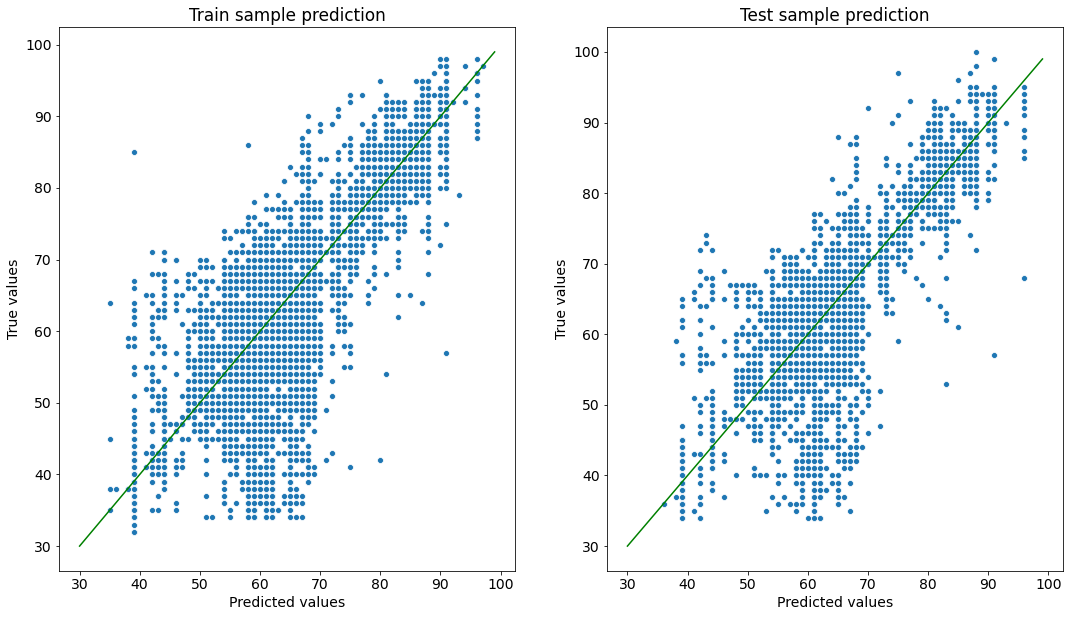

In [29]:
y_train_preds = rf_model.predict(X_train.values)
y_test_preds = rf_model.predict(X_test.values)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

# 9. Внедрение модели

In [30]:
submit = pd.read_csv(SUBMIT_DATASET_PATH)
predictions = rf_model.predict(test_df.values)
submit['mean_exam_points'] = predictions
submit.head()

,Id,mean_exam_points
0,10000,51.0
1,10001,65.0
2,10002,44.0
3,10003,87.0
4,10004,88.0


In [31]:
submit.to_csv('rf_submit.csv', index=False)